# Setup

In [1]:
from rvc.infer.pipeline import Pipeline
from rvc.infer import infer
from rvc.configs.config import Config
from rvc.lib.utils import load_audio_infer, load_embedding
import torch
from scipy import signal
import numpy as np

In [2]:
# Constants and config
config = Config()
sr = 16000
version = 'v1'
device = 'cpu'
encoder_name = 'contentvec'

[CONFIG] Running on CPU, forcing fp32 precision.
File not found: rvc\configs\wavehax\40000.json
File not found: rvc\configs\wavehax\32000.json


In [3]:
# Inputs
audio_input_path = r'assets\audios\könnyek_test.wav'
audio_output_path = r'assets\audios\könnyek_converted_new.wav'
model_path = r'logs\guanguanV1.pth'
model_index = r'logs\guanguanV1.index'
sid = 0

In [4]:
# Load audio
FILTER_ORDER = 5
CUTOFF_FREQUENCY = 48  # Hz
bh, ah = signal.butter(
    N=FILTER_ORDER, Wn=CUTOFF_FREQUENCY, btype="high", fs=sr
)
t_pad = sr * config.x_pad

def load_norm_audio(path):
    audio = load_audio_infer(
        path,
        16000
    )
    audio_max = np.abs(audio).max() / 0.95
    
    if audio_max > 1:
        audio /= audio_max
    return audio

def pad_audio(audio):
    audio_filt = signal.filtfilt(bh, ah, audio)
    audio_pad = np.pad(audio_filt, (t_pad, t_pad), mode="reflect")
    return audio_pad

def load_audio(path):
    return pad_audio(load_norm_audio(path))

audio_pad = load_audio(audio_input_path)

[INFER] loaded audio: assets\audios\könnyek_test.wav
[WARNING] Provided input audio is in stereo. Converting to mono. - For future, please use mono only.


In [5]:
# Load decoder model, initialize pipeline
vc = infer.VoiceConverter()
vc.get_vc(model_path, sid)
pl = vc.vc

# Load encoder model
vc.load_hubert(encoder_name)

Loading .pth file: logs\guanguanV1.pth
    ██████  Vocoder: NSF-HiFi-GAN


In [6]:
# Encode features
feats = pl.extract_feats(vc.hubert_model, audio_pad, version)
feats.shape

torch.Size([1, 1187, 256])

# PCA colorstrip

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

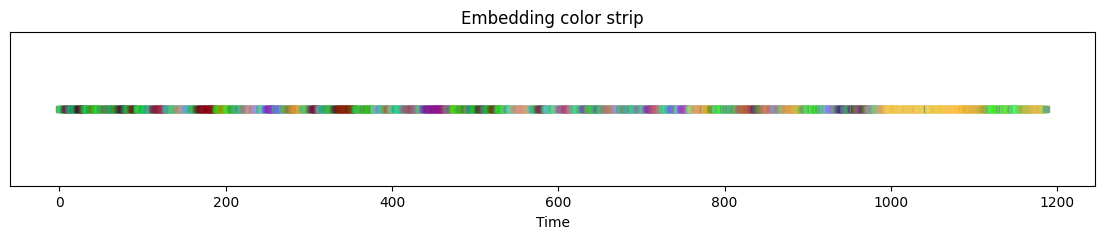

In [8]:
pca = PCA(n_components=3)
feats_pca = pca.fit_transform(feats.squeeze(0))

rgb = np.zeros_like(feats_pca)
for i in range(3):
    pc = feats_pca[:, i]
    rgb[:, i] = (pc - pc.min()) / (pc.max() - pc.min())
time = np.arange(len(feats_pca))

plt.figure(figsize=(14, 2))
plt.scatter(time, np.zeros_like(time), c=rgb, s=20, marker='s')
plt.yticks([])
plt.xlabel("Time")
plt.title("Embedding color strip")
plt.show()

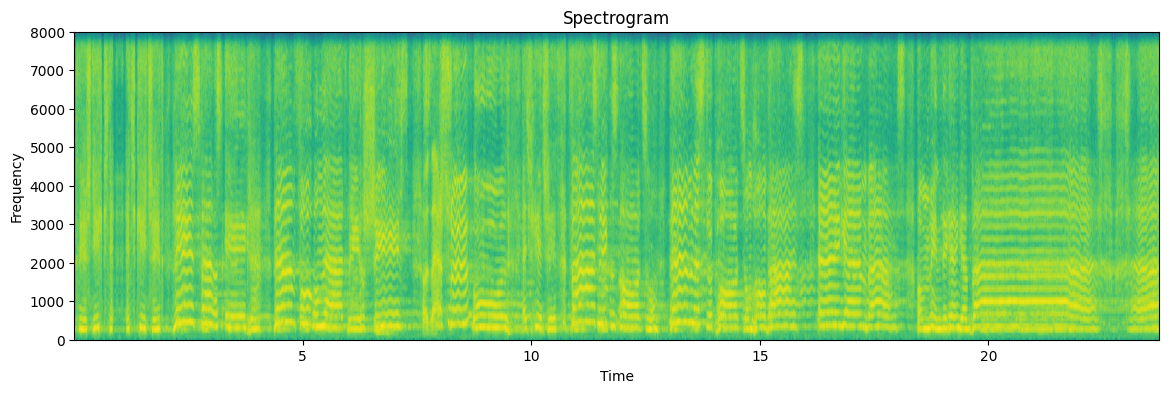

In [9]:
# Spectrogram for comparison
plt.figure(figsize=(14, 4))
plt.specgram(audio_pad, Fs=sr)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()

# Boundary detection

In [10]:
import ruptures as rpt

x = feats.squeeze(0)
model = rpt.KernelCPD(kernel="rbf").fit(x.numpy())
change_points = model.predict(pen=2)
print(change_points)

[22, 30, 70, 95, 111, 129, 140, 152, 161, 169, 189, 205, 220, 230, 240, 249, 259, 272, 281, 293, 302, 311, 318, 329, 336, 356, 370, 380, 391, 402, 414, 431, 440, 464, 474, 485, 505, 529, 538, 548, 568, 585, 600, 618, 627, 638, 654, 671, 688, 705, 716, 725, 735, 757, 766, 783, 795, 815, 836, 845, 857, 866, 875, 891, 901, 919, 928, 936, 956, 976, 984, 997, 1085, 1111, 1120, 1156, 1187]


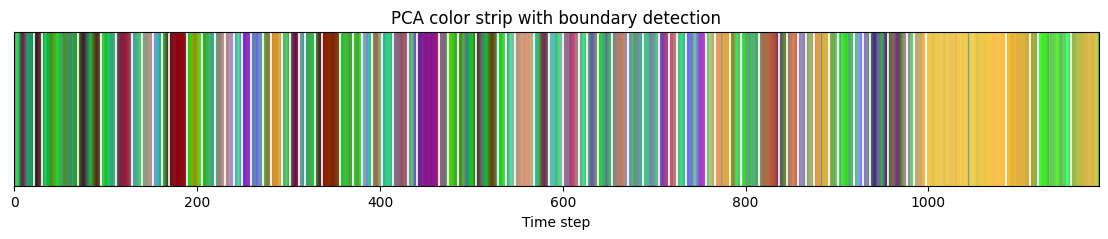

In [11]:
plt.figure(figsize=(14, 2))

plt.imshow(rgb[np.newaxis, :, :], aspect='auto')

for cp in change_points[:-1]:
    plt.axvline(cp, color='white', linewidth=1.2)

plt.yticks([])
plt.xlabel("Time step")
plt.title("PCA color strip with boundary detection")
plt.show()

# Analogies

In [12]:
def get_feats(path):
    audio = load_audio(path)
    return pl.extract_feats(vc.hubert_model, audio, version)

iy_feats = get_feats(r'..\test\vectors\solaria_iy.wav')
ih_feats = get_feats(r'..\test\vectors\solaria_ih.wav')
aa_feats = get_feats(r'..\test\vectors\solaria_aa.wav')

[INFER] loaded audio: ..\test\vectors\solaria_iy.wav
[INFER] loaded audio: ..\test\vectors\solaria_ih.wav
[INFER] loaded audio: ..\test\vectors\solaria_aa.wav


In [13]:
def make_analogy(feats1, feats2):
    x1 = feats1.squeeze(0)
    x2 = feats2.squeeze(0)
    d = x2 - x1
    return d.mean(0)

close_analogy = make_analogy(aa_feats, iy_feats)
assert torch.any(close_analogy != torch.zeros(close_analogy.shape))

In [16]:
# Apply analogy to timeframe
left_idx = 984
right_idx = 1120

feats_converted = feats.clone()
feats_converted[0, left_idx:right_idx, :] += close_analogy

assert torch.any(feats_converted != feats)

# Output

In [17]:
import faiss

index_rate = 0.75 # closeness to original speaker embeddings
protect = 0.5 # closeness to input pitch
seed = 0
window = 160
p_len = audio_pad.shape[0] // window
def convert_voice(in_feats, audio, index_path):
    index = faiss.read_index(index_path)
    big_npy = index.reconstruct_n(0, index.ntotal)
    
    pitch, pitchf = pl.get_f0(
        audio_pad,
        p_len
    )
    pitch = pitch[:p_len]
    pitchf = pitchf[:p_len]
    pitch = torch.tensor(pitch, device=device).unsqueeze(0).long()
    pitchf = torch.tensor(pitchf, device=device).unsqueeze(0).float()

    sid_tensor = torch.tensor(sid, device=device).unsqueeze(0).long()
    return pl.convert_voice(
        in_feats,
        vc.net_g,
        sid_tensor,
        audio,
        pitch,
        pitchf,
        index,
        big_npy,
        index_rate,
        protect,
        seed,
    )

In [18]:
audio_opt = convert_voice(feats_converted[:, left_idx:right_idx, :], audio_pad, model_index)

audio_max = np.abs(audio_opt).max() / 0.99
if audio_max > 1:
    audio_opt /= audio_max

[INFER] Seed kept at: 0; Inference is performed in randomized mode.
[INFER] Randomized seed: 3753699440; Exposed for reproduction.


In [19]:
import soundfile as sf

sf.write(audio_output_path, audio_opt, 40000, format="WAV")